In [79]:
import os
import GOES as GOES

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import pickle


### Ingesta de Archivos .NC GOES

In [12]:
# flist = GOES.download('goes16', 'ABI-L2-ACHAF',
#                       # DateTimeIni = '20230901-000000', DateTimeFin = '20230905-050100',
#                       DateTimeIni = '20230701-000000', DateTimeFin = '20230902-000000',
#                       channel = [''],
#                       # rename_fmt = '%Y%m%d%H%M%S', path_out='C:/Users/Juan Fernando/OneDrive/Escritorio/Master de los Datos/Uniandes/Tesis/')
#                       rename_fmt = '%Y%m%d%H%M%S', path_out='E:\data_tesis/')

### Funciones Usadas en el Código

In [13]:
# Función que permite generar una lista de archivos .nc almacenados en una ruta específica de una fecha inicio a una fecha fin

def list_files_with_extension(path, extension, product, start_date, end_date):
    # Get a list of all files with the specified extension in the specified path
    end_date = end_date + timedelta(hours=5)
    files_list = []
    for foldername, subfolders, filenames in os.walk(path): . 
        for filename in filenames:
            if filename.endswith(extension) and product in filename:
                if extension == '.nc':
                    file_date = datetime.strptime(filename[filename.find("_s") + 2:filename.rfind(".")], "%Y%m%d%H%M%S") # Extrae la parte de la cadena que representa la fecha
                elif extension == '.npy':
                    file_date = datetime.strptime(filename[filename.find("_") + 1:filename.rfind(".")],"%Y_%m_%d_%H_%M")
                else:
                    break;
                if start_date <= file_date <= end_date:    # Valida que el archivo este dentro de rango de fecha indicado
                    files_list.append(os.path.join(foldername, filename))
    files_list = sorted(files_list)  # Ordena la lista creada de mas antiguo a mas reciente
    return files_list

In [14]:
# Función que permite extraer de cada archivo .nc la matriz con información del producto a usar y almacenar la matriz en un archivo binario numpy

def extract_matriz_goes(archivo,producto,ruta_almacenamiento = ''):
    nc = GOES.open_dataset(archivo)
    file_date = datetime.strptime(archivo[archivo.find("_s") + 2:archivo.rfind(".")],"%Y%m%d%H%M%S")
    # file_date_ = file_date.strftime("%Y-%m-%d %H:%M:%S")
    file_date_ = file_date.strftime("%Y-%m-%d %H:%M")
    file_date_2 = file_date.strftime("%Y_%m_%d_%H_%M")

    # Get the latitude and longitude image bounds
#     domain = [-85.0,-30.0,-5.0,15.0]
#     domain = [-76.0,-71.0,5.0,13.0]
    domain = [-75.0,-70.0,8.0,13.0]
    data, LonCor, LatCor = nc.image(producto, lonlat='corner', domain=domain)

    matriz = data.data
    matriz = np.nan_to_num(matriz, nan=0)
    
    if ruta_almacenamiento != '':
        np.save(ruta_almacenamiento + '{}_{}.npy'.format(producto, file_date_2), matriz)
        

    print('Proceso Completo '+archivo)

    return matriz, file_date_

In [15]:
# Función que permite crear un diccionario de matrices a partir de los archivos .nc o de matrices extraidas anterirmente, 
#donde la llave es la fecha y el valor la matriz

def create_dict_matrix_goes(files,start_date,end_date,producto,ruta_almacenamiento, nc = True):
    # Definimos el diccionario vacio
    datos_producto_goes = {}
    datos_imputados = []

    # Define un incremento de tiempo (10 minutos) para validar que exista un archivo para cada intervalo, creamos una lista vacia para almacenar los tiempos a comparar
    time_increment = timedelta(minutes=10)
    date_list = []

    # Generamos la lista de fechas entre start_date y end_date
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date)
        current_date += time_increment

    if nc:     
        for date in date_list:
            for file in files:
                file_date = datetime.strptime(file[file.find("_s") + 2:file.rfind(".")-2],"%Y%m%d%H%M")
                file_date = file_date - timedelta(hours=5) # Se le quitan 5 horas al archivo para emparejar con hora colombia
                if date < file_date:
                    matriz, _ = extract_matriz_goes(file,producto,ruta_almacenamiento)
                    fecha = date.strftime("%Y-%m-%d %H:%M")
                    datos_producto_goes[fecha] = matriz
                    datos_imputados.append(fecha)
                    break;
                elif date == file_date:
                    matriz,_ = extract_matriz_goes(file,producto,ruta_almacenamiento)
                    fecha = date.strftime("%Y-%m-%d %H:%M")
                    datos_producto_goes[fecha] = matriz
                    break;
    else:
        for date in date_list:
            for file in files:
                file_date = datetime.strptime(file[file.rfind("2023") + 0:file.rfind(".")],"%Y_%m_%d_%H_%M")
                file_date = file_date - timedelta(hours=5) # Se le quitan 5 horas al archivo para emparejar con hora colombia
                if date < file_date:
                    matriz = np.load(file)
                    fecha = date.strftime("%Y-%m-%d %H:%M")
                    datos_producto_goes[fecha] = matriz
                    datos_imputados.append(fecha)
                    print('Matriz Imputada: ' + str(fecha))
                    break;
                elif date == file_date:
                    matriz = np.load(file)
                    fecha = date.strftime("%Y-%m-%d %H:%M")
                    datos_producto_goes[fecha] = matriz
                    print('Matriz Creada: ' + str(fecha))
                    break;
        

    return datos_producto_goes, datos_imputados

### Llamado a función para enlistar archivos o matrices a usar

In [16]:
# path = 'C:/Users/Juan Fernando/OneDrive/Escritorio/Master de los Datos/Uniandes/Tesis/'
path = 'E:\data_matrices/'
extension = ".npy"
product = 'HT'
start_date = datetime(2023, 7, 1, 0, 0, 0)
end_date = datetime(2023, 8, 31, 23, 59, 0)
files = list_files_with_extension(path, extension, product, start_date, end_date)

In [17]:
files[-10:]

['E:\\data_matrices/HT_2023_09_01_03_20.npy',
 'E:\\data_matrices/HT_2023_09_01_03_30.npy',
 'E:\\data_matrices/HT_2023_09_01_03_40.npy',
 'E:\\data_matrices/HT_2023_09_01_03_50.npy',
 'E:\\data_matrices/HT_2023_09_01_04_00.npy',
 'E:\\data_matrices/HT_2023_09_01_04_10.npy',
 'E:\\data_matrices/HT_2023_09_01_04_20.npy',
 'E:\\data_matrices/HT_2023_09_01_04_30.npy',
 'E:\\data_matrices/HT_2023_09_01_04_40.npy',
 'E:\\data_matrices/HT_2023_09_01_04_50.npy']

### Llamado a función para creación de Diccionario de Matrices

In [18]:
%%time

files = files

start_date = datetime(2023, 7, 1, 0, 0)  # Cambia esto a tu fecha de inicio
end_date = datetime(2023, 8, 31, 23, 59)    # Cambia esto a tu fecha de fin
producto = 'HT'
ruta_almacenamiento = 'E:\data_matrices/'

nc = False  # True para generar matrices desde archivos nc y almacenarlas en ruta 
           # False para llamar matrices ya almacenadas en la ruta, saltandose el proceso de generación

datos_goes, datos_imputados = create_dict_matrix_goes(files,start_date,end_date,producto,ruta_almacenamiento,nc)

Matriz Creada: 2023-07-01 00:00
Matriz Creada: 2023-07-01 00:10
Matriz Creada: 2023-07-01 00:20
Matriz Creada: 2023-07-01 00:30
Matriz Creada: 2023-07-01 00:40
Matriz Creada: 2023-07-01 00:50
Matriz Creada: 2023-07-01 01:00
Matriz Creada: 2023-07-01 01:10
Matriz Creada: 2023-07-01 01:20
Matriz Creada: 2023-07-01 01:30
Matriz Creada: 2023-07-01 01:40
Matriz Creada: 2023-07-01 01:50
Matriz Creada: 2023-07-01 02:00
Matriz Creada: 2023-07-01 02:10
Matriz Creada: 2023-07-01 02:20
Matriz Creada: 2023-07-01 02:30
Matriz Creada: 2023-07-01 02:40
Matriz Creada: 2023-07-01 02:50
Matriz Creada: 2023-07-01 03:00
Matriz Creada: 2023-07-01 03:10
Matriz Creada: 2023-07-01 03:20
Matriz Creada: 2023-07-01 03:30
Matriz Creada: 2023-07-01 03:40
Matriz Creada: 2023-07-01 03:50
Matriz Creada: 2023-07-01 04:00
Matriz Creada: 2023-07-01 04:10
Matriz Creada: 2023-07-01 04:20
Matriz Creada: 2023-07-01 04:30
Matriz Creada: 2023-07-01 04:40
Matriz Creada: 2023-07-01 04:50
Matriz Creada: 2023-07-01 05:00
Matriz C

Matriz Creada: 2023-07-02 19:40
Matriz Creada: 2023-07-02 19:50
Matriz Creada: 2023-07-02 20:00
Matriz Creada: 2023-07-02 20:10
Matriz Creada: 2023-07-02 20:20
Matriz Creada: 2023-07-02 20:30
Matriz Creada: 2023-07-02 20:40
Matriz Creada: 2023-07-02 20:50
Matriz Creada: 2023-07-02 21:00
Matriz Creada: 2023-07-02 21:10
Matriz Creada: 2023-07-02 21:20
Matriz Creada: 2023-07-02 21:30
Matriz Creada: 2023-07-02 21:40
Matriz Creada: 2023-07-02 21:50
Matriz Creada: 2023-07-02 22:00
Matriz Creada: 2023-07-02 22:10
Matriz Creada: 2023-07-02 22:20
Matriz Creada: 2023-07-02 22:30
Matriz Creada: 2023-07-02 22:40
Matriz Creada: 2023-07-02 22:50
Matriz Creada: 2023-07-02 23:00
Matriz Creada: 2023-07-02 23:10
Matriz Creada: 2023-07-02 23:20
Matriz Creada: 2023-07-02 23:30
Matriz Creada: 2023-07-02 23:40
Matriz Creada: 2023-07-02 23:50
Matriz Creada: 2023-07-03 00:00
Matriz Creada: 2023-07-03 00:10
Matriz Creada: 2023-07-03 00:20
Matriz Creada: 2023-07-03 00:30
Matriz Creada: 2023-07-03 00:40
Matriz C

Matriz Creada: 2023-07-04 16:50
Matriz Creada: 2023-07-04 17:00
Matriz Creada: 2023-07-04 17:10
Matriz Creada: 2023-07-04 17:20
Matriz Creada: 2023-07-04 17:30
Matriz Creada: 2023-07-04 17:40
Matriz Creada: 2023-07-04 17:50
Matriz Creada: 2023-07-04 18:00
Matriz Creada: 2023-07-04 18:10
Matriz Creada: 2023-07-04 18:20
Matriz Creada: 2023-07-04 18:30
Matriz Creada: 2023-07-04 18:40
Matriz Creada: 2023-07-04 18:50
Matriz Creada: 2023-07-04 19:00
Matriz Creada: 2023-07-04 19:10
Matriz Creada: 2023-07-04 19:20
Matriz Creada: 2023-07-04 19:30
Matriz Creada: 2023-07-04 19:40
Matriz Creada: 2023-07-04 19:50
Matriz Creada: 2023-07-04 20:00
Matriz Creada: 2023-07-04 20:10
Matriz Creada: 2023-07-04 20:20
Matriz Creada: 2023-07-04 20:30
Matriz Creada: 2023-07-04 20:40
Matriz Creada: 2023-07-04 20:50
Matriz Creada: 2023-07-04 21:00
Matriz Creada: 2023-07-04 21:10
Matriz Creada: 2023-07-04 21:20
Matriz Creada: 2023-07-04 21:30
Matriz Creada: 2023-07-04 21:40
Matriz Creada: 2023-07-04 21:50
Matriz C

Matriz Creada: 2023-07-06 13:30
Matriz Creada: 2023-07-06 13:40
Matriz Creada: 2023-07-06 13:50
Matriz Creada: 2023-07-06 14:00
Matriz Creada: 2023-07-06 14:10
Matriz Creada: 2023-07-06 14:20
Matriz Creada: 2023-07-06 14:30
Matriz Creada: 2023-07-06 14:40
Matriz Creada: 2023-07-06 14:50
Matriz Creada: 2023-07-06 15:00
Matriz Creada: 2023-07-06 15:10
Matriz Creada: 2023-07-06 15:20
Matriz Creada: 2023-07-06 15:30
Matriz Creada: 2023-07-06 15:40
Matriz Creada: 2023-07-06 15:50
Matriz Creada: 2023-07-06 16:00
Matriz Creada: 2023-07-06 16:10
Matriz Creada: 2023-07-06 16:20
Matriz Creada: 2023-07-06 16:30
Matriz Creada: 2023-07-06 16:40
Matriz Creada: 2023-07-06 16:50
Matriz Creada: 2023-07-06 17:00
Matriz Creada: 2023-07-06 17:10
Matriz Creada: 2023-07-06 17:20
Matriz Creada: 2023-07-06 17:30
Matriz Creada: 2023-07-06 17:40
Matriz Creada: 2023-07-06 17:50
Matriz Creada: 2023-07-06 18:00
Matriz Creada: 2023-07-06 18:10
Matriz Creada: 2023-07-06 18:20
Matriz Creada: 2023-07-06 18:30
Matriz C

Matriz Creada: 2023-07-08 08:30
Matriz Creada: 2023-07-08 08:40
Matriz Creada: 2023-07-08 08:50
Matriz Creada: 2023-07-08 09:00
Matriz Creada: 2023-07-08 09:10
Matriz Creada: 2023-07-08 09:20
Matriz Creada: 2023-07-08 09:30
Matriz Creada: 2023-07-08 09:40
Matriz Creada: 2023-07-08 09:50
Matriz Creada: 2023-07-08 10:00
Matriz Creada: 2023-07-08 10:10
Matriz Creada: 2023-07-08 10:20
Matriz Creada: 2023-07-08 10:30
Matriz Creada: 2023-07-08 10:40
Matriz Creada: 2023-07-08 10:50
Matriz Creada: 2023-07-08 11:00
Matriz Creada: 2023-07-08 11:10
Matriz Creada: 2023-07-08 11:20
Matriz Creada: 2023-07-08 11:30
Matriz Creada: 2023-07-08 11:40
Matriz Creada: 2023-07-08 11:50
Matriz Creada: 2023-07-08 12:00
Matriz Creada: 2023-07-08 12:10
Matriz Creada: 2023-07-08 12:20
Matriz Creada: 2023-07-08 12:30
Matriz Creada: 2023-07-08 12:40
Matriz Creada: 2023-07-08 12:50
Matriz Creada: 2023-07-08 13:00
Matriz Creada: 2023-07-08 13:10
Matriz Creada: 2023-07-08 13:20
Matriz Creada: 2023-07-08 13:30
Matriz C

Matriz Creada: 2023-07-10 04:20
Matriz Creada: 2023-07-10 04:30
Matriz Creada: 2023-07-10 04:40
Matriz Creada: 2023-07-10 04:50
Matriz Creada: 2023-07-10 05:00
Matriz Creada: 2023-07-10 05:10
Matriz Creada: 2023-07-10 05:20
Matriz Creada: 2023-07-10 05:30
Matriz Creada: 2023-07-10 05:40
Matriz Creada: 2023-07-10 05:50
Matriz Creada: 2023-07-10 06:00
Matriz Creada: 2023-07-10 06:10
Matriz Creada: 2023-07-10 06:20
Matriz Creada: 2023-07-10 06:30
Matriz Creada: 2023-07-10 06:40
Matriz Creada: 2023-07-10 06:50
Matriz Creada: 2023-07-10 07:00
Matriz Creada: 2023-07-10 07:10
Matriz Creada: 2023-07-10 07:20
Matriz Creada: 2023-07-10 07:30
Matriz Creada: 2023-07-10 07:40
Matriz Creada: 2023-07-10 07:50
Matriz Creada: 2023-07-10 08:00
Matriz Creada: 2023-07-10 08:10
Matriz Creada: 2023-07-10 08:20
Matriz Creada: 2023-07-10 08:30
Matriz Creada: 2023-07-10 08:40
Matriz Creada: 2023-07-10 08:50
Matriz Creada: 2023-07-10 09:00
Matriz Creada: 2023-07-10 09:10
Matriz Creada: 2023-07-10 09:20
Matriz C

Matriz Creada: 2023-07-12 00:50
Matriz Creada: 2023-07-12 01:00
Matriz Creada: 2023-07-12 01:10
Matriz Creada: 2023-07-12 01:20
Matriz Creada: 2023-07-12 01:30
Matriz Creada: 2023-07-12 01:40
Matriz Creada: 2023-07-12 01:50
Matriz Creada: 2023-07-12 02:00
Matriz Creada: 2023-07-12 02:10
Matriz Creada: 2023-07-12 02:20
Matriz Creada: 2023-07-12 02:30
Matriz Creada: 2023-07-12 02:40
Matriz Creada: 2023-07-12 02:50
Matriz Creada: 2023-07-12 03:00
Matriz Creada: 2023-07-12 03:10
Matriz Creada: 2023-07-12 03:20
Matriz Creada: 2023-07-12 03:30
Matriz Creada: 2023-07-12 03:40
Matriz Creada: 2023-07-12 03:50
Matriz Creada: 2023-07-12 04:00
Matriz Creada: 2023-07-12 04:10
Matriz Creada: 2023-07-12 04:20
Matriz Creada: 2023-07-12 04:30
Matriz Creada: 2023-07-12 04:40
Matriz Creada: 2023-07-12 04:50
Matriz Creada: 2023-07-12 05:00
Matriz Creada: 2023-07-12 05:10
Matriz Creada: 2023-07-12 05:20
Matriz Creada: 2023-07-12 05:30
Matriz Creada: 2023-07-12 05:40
Matriz Creada: 2023-07-12 05:50
Matriz C

Matriz Creada: 2023-07-13 20:30
Matriz Creada: 2023-07-13 20:40
Matriz Creada: 2023-07-13 20:50
Matriz Creada: 2023-07-13 21:00
Matriz Creada: 2023-07-13 21:10
Matriz Creada: 2023-07-13 21:20
Matriz Creada: 2023-07-13 21:30
Matriz Creada: 2023-07-13 21:40
Matriz Creada: 2023-07-13 21:50
Matriz Creada: 2023-07-13 22:00
Matriz Creada: 2023-07-13 22:10
Matriz Creada: 2023-07-13 22:20
Matriz Creada: 2023-07-13 22:30
Matriz Creada: 2023-07-13 22:40
Matriz Creada: 2023-07-13 22:50
Matriz Creada: 2023-07-13 23:00
Matriz Creada: 2023-07-13 23:10
Matriz Creada: 2023-07-13 23:20
Matriz Creada: 2023-07-13 23:30
Matriz Creada: 2023-07-13 23:40
Matriz Creada: 2023-07-13 23:50
Matriz Creada: 2023-07-14 00:00
Matriz Creada: 2023-07-14 00:10
Matriz Creada: 2023-07-14 00:20
Matriz Creada: 2023-07-14 00:30
Matriz Creada: 2023-07-14 00:40
Matriz Creada: 2023-07-14 00:50
Matriz Creada: 2023-07-14 01:00
Matriz Creada: 2023-07-14 01:10
Matriz Creada: 2023-07-14 01:20
Matriz Creada: 2023-07-14 01:30
Matriz C

Matriz Creada: 2023-07-15 15:30
Matriz Creada: 2023-07-15 15:40
Matriz Creada: 2023-07-15 15:50
Matriz Creada: 2023-07-15 16:00
Matriz Creada: 2023-07-15 16:10
Matriz Creada: 2023-07-15 16:20
Matriz Creada: 2023-07-15 16:30
Matriz Creada: 2023-07-15 16:40
Matriz Creada: 2023-07-15 16:50
Matriz Creada: 2023-07-15 17:00
Matriz Creada: 2023-07-15 17:10
Matriz Creada: 2023-07-15 17:20
Matriz Creada: 2023-07-15 17:30
Matriz Creada: 2023-07-15 17:40
Matriz Creada: 2023-07-15 17:50
Matriz Creada: 2023-07-15 18:00
Matriz Creada: 2023-07-15 18:10
Matriz Creada: 2023-07-15 18:20
Matriz Creada: 2023-07-15 18:30
Matriz Creada: 2023-07-15 18:40
Matriz Creada: 2023-07-15 18:50
Matriz Creada: 2023-07-15 19:00
Matriz Creada: 2023-07-15 19:10
Matriz Creada: 2023-07-15 19:20
Matriz Creada: 2023-07-15 19:30
Matriz Creada: 2023-07-15 19:40
Matriz Creada: 2023-07-15 19:50
Matriz Creada: 2023-07-15 20:00
Matriz Creada: 2023-07-15 20:10
Matriz Creada: 2023-07-15 20:20
Matriz Creada: 2023-07-15 20:30
Matriz C

Matriz Creada: 2023-07-17 10:50
Matriz Creada: 2023-07-17 11:00
Matriz Creada: 2023-07-17 11:10
Matriz Creada: 2023-07-17 11:20
Matriz Creada: 2023-07-17 11:30
Matriz Creada: 2023-07-17 11:40
Matriz Creada: 2023-07-17 11:50
Matriz Creada: 2023-07-17 12:00
Matriz Creada: 2023-07-17 12:10
Matriz Creada: 2023-07-17 12:20
Matriz Creada: 2023-07-17 12:30
Matriz Creada: 2023-07-17 12:40
Matriz Creada: 2023-07-17 12:50
Matriz Creada: 2023-07-17 13:00
Matriz Creada: 2023-07-17 13:10
Matriz Creada: 2023-07-17 13:20
Matriz Creada: 2023-07-17 13:30
Matriz Creada: 2023-07-17 13:40
Matriz Creada: 2023-07-17 13:50
Matriz Creada: 2023-07-17 14:00
Matriz Creada: 2023-07-17 14:10
Matriz Creada: 2023-07-17 14:20
Matriz Creada: 2023-07-17 14:30
Matriz Creada: 2023-07-17 14:40
Matriz Creada: 2023-07-17 14:50
Matriz Creada: 2023-07-17 15:00
Matriz Creada: 2023-07-17 15:10
Matriz Creada: 2023-07-17 15:20
Matriz Creada: 2023-07-17 15:30
Matriz Creada: 2023-07-17 15:40
Matriz Creada: 2023-07-17 15:50
Matriz C

Matriz Creada: 2023-07-19 06:40
Matriz Creada: 2023-07-19 06:50
Matriz Creada: 2023-07-19 07:00
Matriz Creada: 2023-07-19 07:10
Matriz Creada: 2023-07-19 07:20
Matriz Creada: 2023-07-19 07:30
Matriz Creada: 2023-07-19 07:40
Matriz Creada: 2023-07-19 07:50
Matriz Creada: 2023-07-19 08:00
Matriz Creada: 2023-07-19 08:10
Matriz Creada: 2023-07-19 08:20
Matriz Creada: 2023-07-19 08:30
Matriz Creada: 2023-07-19 08:40
Matriz Creada: 2023-07-19 08:50
Matriz Creada: 2023-07-19 09:00
Matriz Creada: 2023-07-19 09:10
Matriz Creada: 2023-07-19 09:20
Matriz Creada: 2023-07-19 09:30
Matriz Creada: 2023-07-19 09:40
Matriz Creada: 2023-07-19 09:50
Matriz Creada: 2023-07-19 10:00
Matriz Creada: 2023-07-19 10:10
Matriz Creada: 2023-07-19 10:20
Matriz Creada: 2023-07-19 10:30
Matriz Creada: 2023-07-19 10:40
Matriz Creada: 2023-07-19 10:50
Matriz Creada: 2023-07-19 11:00
Matriz Creada: 2023-07-19 11:10
Matriz Creada: 2023-07-19 11:20
Matriz Creada: 2023-07-19 11:30
Matriz Creada: 2023-07-19 11:40
Matriz C

Matriz Creada: 2023-07-21 02:10
Matriz Creada: 2023-07-21 02:20
Matriz Creada: 2023-07-21 02:30
Matriz Creada: 2023-07-21 02:40
Matriz Creada: 2023-07-21 02:50
Matriz Creada: 2023-07-21 03:00
Matriz Creada: 2023-07-21 03:10
Matriz Creada: 2023-07-21 03:20
Matriz Creada: 2023-07-21 03:30
Matriz Creada: 2023-07-21 03:40
Matriz Creada: 2023-07-21 03:50
Matriz Creada: 2023-07-21 04:00
Matriz Creada: 2023-07-21 04:10
Matriz Creada: 2023-07-21 04:20
Matriz Creada: 2023-07-21 04:30
Matriz Creada: 2023-07-21 04:40
Matriz Creada: 2023-07-21 04:50
Matriz Creada: 2023-07-21 05:00
Matriz Creada: 2023-07-21 05:10
Matriz Creada: 2023-07-21 05:20
Matriz Creada: 2023-07-21 05:30
Matriz Creada: 2023-07-21 05:40
Matriz Creada: 2023-07-21 05:50
Matriz Creada: 2023-07-21 06:00
Matriz Creada: 2023-07-21 06:10
Matriz Creada: 2023-07-21 06:20
Matriz Creada: 2023-07-21 06:30
Matriz Creada: 2023-07-21 06:40
Matriz Creada: 2023-07-21 06:50
Matriz Creada: 2023-07-21 07:00
Matriz Creada: 2023-07-21 07:10
Matriz C

Matriz Creada: 2023-07-22 21:00
Matriz Creada: 2023-07-22 21:10
Matriz Creada: 2023-07-22 21:20
Matriz Creada: 2023-07-22 21:30
Matriz Creada: 2023-07-22 21:40
Matriz Creada: 2023-07-22 21:50
Matriz Creada: 2023-07-22 22:00
Matriz Creada: 2023-07-22 22:10
Matriz Creada: 2023-07-22 22:20
Matriz Creada: 2023-07-22 22:30
Matriz Creada: 2023-07-22 22:40
Matriz Creada: 2023-07-22 22:50
Matriz Creada: 2023-07-22 23:00
Matriz Creada: 2023-07-22 23:10
Matriz Creada: 2023-07-22 23:20
Matriz Creada: 2023-07-22 23:30
Matriz Creada: 2023-07-22 23:40
Matriz Creada: 2023-07-22 23:50
Matriz Creada: 2023-07-23 00:00
Matriz Creada: 2023-07-23 00:10
Matriz Creada: 2023-07-23 00:20
Matriz Creada: 2023-07-23 00:30
Matriz Creada: 2023-07-23 00:40
Matriz Creada: 2023-07-23 00:50
Matriz Creada: 2023-07-23 01:00
Matriz Creada: 2023-07-23 01:10
Matriz Creada: 2023-07-23 01:20
Matriz Creada: 2023-07-23 01:30
Matriz Creada: 2023-07-23 01:40
Matriz Creada: 2023-07-23 01:50
Matriz Creada: 2023-07-23 02:00
Matriz C

Matriz Creada: 2023-07-24 15:50
Matriz Creada: 2023-07-24 16:00
Matriz Creada: 2023-07-24 16:10
Matriz Creada: 2023-07-24 16:20
Matriz Creada: 2023-07-24 16:30
Matriz Creada: 2023-07-24 16:40
Matriz Creada: 2023-07-24 16:50
Matriz Creada: 2023-07-24 17:00
Matriz Creada: 2023-07-24 17:10
Matriz Creada: 2023-07-24 17:20
Matriz Creada: 2023-07-24 17:30
Matriz Creada: 2023-07-24 17:40
Matriz Creada: 2023-07-24 17:50
Matriz Creada: 2023-07-24 18:00
Matriz Creada: 2023-07-24 18:10
Matriz Creada: 2023-07-24 18:20
Matriz Creada: 2023-07-24 18:30
Matriz Creada: 2023-07-24 18:40
Matriz Creada: 2023-07-24 18:50
Matriz Creada: 2023-07-24 19:00
Matriz Creada: 2023-07-24 19:10
Matriz Creada: 2023-07-24 19:20
Matriz Creada: 2023-07-24 19:30
Matriz Creada: 2023-07-24 19:40
Matriz Creada: 2023-07-24 19:50
Matriz Creada: 2023-07-24 20:00
Matriz Creada: 2023-07-24 20:10
Matriz Creada: 2023-07-24 20:20
Matriz Creada: 2023-07-24 20:30
Matriz Creada: 2023-07-24 20:40
Matriz Creada: 2023-07-24 20:50
Matriz C

Matriz Creada: 2023-07-26 10:30
Matriz Creada: 2023-07-26 10:40
Matriz Creada: 2023-07-26 10:50
Matriz Creada: 2023-07-26 11:00
Matriz Creada: 2023-07-26 11:10
Matriz Creada: 2023-07-26 11:20
Matriz Creada: 2023-07-26 11:30
Matriz Creada: 2023-07-26 11:40
Matriz Creada: 2023-07-26 11:50
Matriz Creada: 2023-07-26 12:00
Matriz Creada: 2023-07-26 12:10
Matriz Creada: 2023-07-26 12:20
Matriz Creada: 2023-07-26 12:30
Matriz Creada: 2023-07-26 12:40
Matriz Creada: 2023-07-26 12:50
Matriz Creada: 2023-07-26 13:00
Matriz Creada: 2023-07-26 13:10
Matriz Creada: 2023-07-26 13:20
Matriz Creada: 2023-07-26 13:30
Matriz Creada: 2023-07-26 13:40
Matriz Creada: 2023-07-26 13:50
Matriz Creada: 2023-07-26 14:00
Matriz Creada: 2023-07-26 14:10
Matriz Creada: 2023-07-26 14:20
Matriz Creada: 2023-07-26 14:30
Matriz Creada: 2023-07-26 14:40
Matriz Creada: 2023-07-26 14:50
Matriz Creada: 2023-07-26 15:00
Matriz Creada: 2023-07-26 15:10
Matriz Creada: 2023-07-26 15:20
Matriz Creada: 2023-07-26 15:30
Matriz C

Matriz Creada: 2023-07-28 05:20
Matriz Creada: 2023-07-28 05:30
Matriz Creada: 2023-07-28 05:40
Matriz Creada: 2023-07-28 05:50
Matriz Creada: 2023-07-28 06:00
Matriz Creada: 2023-07-28 06:10
Matriz Creada: 2023-07-28 06:20
Matriz Creada: 2023-07-28 06:30
Matriz Creada: 2023-07-28 06:40
Matriz Creada: 2023-07-28 06:50
Matriz Creada: 2023-07-28 07:00
Matriz Creada: 2023-07-28 07:10
Matriz Creada: 2023-07-28 07:20
Matriz Creada: 2023-07-28 07:30
Matriz Creada: 2023-07-28 07:40
Matriz Creada: 2023-07-28 07:50
Matriz Creada: 2023-07-28 08:00
Matriz Creada: 2023-07-28 08:10
Matriz Creada: 2023-07-28 08:20
Matriz Creada: 2023-07-28 08:30
Matriz Creada: 2023-07-28 08:40
Matriz Creada: 2023-07-28 08:50
Matriz Creada: 2023-07-28 09:00
Matriz Creada: 2023-07-28 09:10
Matriz Creada: 2023-07-28 09:20
Matriz Creada: 2023-07-28 09:30
Matriz Creada: 2023-07-28 09:40
Matriz Creada: 2023-07-28 09:50
Matriz Creada: 2023-07-28 10:00
Matriz Creada: 2023-07-28 10:10
Matriz Creada: 2023-07-28 10:20
Matriz C

Matriz Creada: 2023-07-30 00:30
Matriz Creada: 2023-07-30 00:40
Matriz Creada: 2023-07-30 00:50
Matriz Creada: 2023-07-30 01:00
Matriz Creada: 2023-07-30 01:10
Matriz Creada: 2023-07-30 01:20
Matriz Creada: 2023-07-30 01:30
Matriz Creada: 2023-07-30 01:40
Matriz Creada: 2023-07-30 01:50
Matriz Creada: 2023-07-30 02:00
Matriz Creada: 2023-07-30 02:10
Matriz Creada: 2023-07-30 02:20
Matriz Creada: 2023-07-30 02:30
Matriz Creada: 2023-07-30 02:40
Matriz Creada: 2023-07-30 02:50
Matriz Creada: 2023-07-30 03:00
Matriz Creada: 2023-07-30 03:10
Matriz Creada: 2023-07-30 03:20
Matriz Creada: 2023-07-30 03:30
Matriz Creada: 2023-07-30 03:40
Matriz Creada: 2023-07-30 03:50
Matriz Creada: 2023-07-30 04:00
Matriz Creada: 2023-07-30 04:10
Matriz Creada: 2023-07-30 04:20
Matriz Creada: 2023-07-30 04:30
Matriz Creada: 2023-07-30 04:40
Matriz Creada: 2023-07-30 04:50
Matriz Creada: 2023-07-30 05:00
Matriz Creada: 2023-07-30 05:10
Matriz Creada: 2023-07-30 05:20
Matriz Creada: 2023-07-30 05:30
Matriz C

Matriz Creada: 2023-07-31 19:20
Matriz Creada: 2023-07-31 19:30
Matriz Creada: 2023-07-31 19:40
Matriz Creada: 2023-07-31 19:50
Matriz Creada: 2023-07-31 20:00
Matriz Creada: 2023-07-31 20:10
Matriz Creada: 2023-07-31 20:20
Matriz Creada: 2023-07-31 20:30
Matriz Creada: 2023-07-31 20:40
Matriz Creada: 2023-07-31 20:50
Matriz Creada: 2023-07-31 21:00
Matriz Creada: 2023-07-31 21:10
Matriz Creada: 2023-07-31 21:20
Matriz Creada: 2023-07-31 21:30
Matriz Creada: 2023-07-31 21:40
Matriz Creada: 2023-07-31 21:50
Matriz Creada: 2023-07-31 22:00
Matriz Creada: 2023-07-31 22:10
Matriz Creada: 2023-07-31 22:20
Matriz Creada: 2023-07-31 22:30
Matriz Creada: 2023-07-31 22:40
Matriz Creada: 2023-07-31 22:50
Matriz Creada: 2023-07-31 23:00
Matriz Creada: 2023-07-31 23:10
Matriz Creada: 2023-07-31 23:20
Matriz Creada: 2023-07-31 23:30
Matriz Creada: 2023-07-31 23:40
Matriz Creada: 2023-07-31 23:50
Matriz Creada: 2023-08-01 00:00
Matriz Creada: 2023-08-01 00:10
Matriz Creada: 2023-08-01 00:20
Matriz C

Matriz Creada: 2023-08-02 14:20
Matriz Creada: 2023-08-02 14:30
Matriz Creada: 2023-08-02 14:40
Matriz Creada: 2023-08-02 14:50
Matriz Creada: 2023-08-02 15:00
Matriz Creada: 2023-08-02 15:10
Matriz Creada: 2023-08-02 15:20
Matriz Creada: 2023-08-02 15:30
Matriz Creada: 2023-08-02 15:40
Matriz Creada: 2023-08-02 15:50
Matriz Creada: 2023-08-02 16:00
Matriz Creada: 2023-08-02 16:10
Matriz Creada: 2023-08-02 16:20
Matriz Creada: 2023-08-02 16:30
Matriz Creada: 2023-08-02 16:40
Matriz Creada: 2023-08-02 16:50
Matriz Creada: 2023-08-02 17:00
Matriz Creada: 2023-08-02 17:10
Matriz Creada: 2023-08-02 17:20
Matriz Creada: 2023-08-02 17:30
Matriz Creada: 2023-08-02 17:40
Matriz Creada: 2023-08-02 17:50
Matriz Creada: 2023-08-02 18:00
Matriz Creada: 2023-08-02 18:10
Matriz Creada: 2023-08-02 18:20
Matriz Creada: 2023-08-02 18:30
Matriz Creada: 2023-08-02 18:40
Matriz Creada: 2023-08-02 18:50
Matriz Creada: 2023-08-02 19:00
Matriz Creada: 2023-08-02 19:10
Matriz Creada: 2023-08-02 19:20
Matriz C

Matriz Creada: 2023-08-04 09:20
Matriz Creada: 2023-08-04 09:30
Matriz Creada: 2023-08-04 09:40
Matriz Creada: 2023-08-04 09:50
Matriz Creada: 2023-08-04 10:00
Matriz Creada: 2023-08-04 10:10
Matriz Creada: 2023-08-04 10:20
Matriz Creada: 2023-08-04 10:30
Matriz Creada: 2023-08-04 10:40
Matriz Creada: 2023-08-04 10:50
Matriz Creada: 2023-08-04 11:00
Matriz Creada: 2023-08-04 11:10
Matriz Creada: 2023-08-04 11:20
Matriz Creada: 2023-08-04 11:30
Matriz Creada: 2023-08-04 11:40
Matriz Creada: 2023-08-04 11:50
Matriz Creada: 2023-08-04 12:00
Matriz Creada: 2023-08-04 12:10
Matriz Creada: 2023-08-04 12:20
Matriz Creada: 2023-08-04 12:30
Matriz Creada: 2023-08-04 12:40
Matriz Creada: 2023-08-04 12:50
Matriz Creada: 2023-08-04 13:00
Matriz Creada: 2023-08-04 13:10
Matriz Creada: 2023-08-04 13:20
Matriz Creada: 2023-08-04 13:30
Matriz Creada: 2023-08-04 13:40
Matriz Creada: 2023-08-04 13:50
Matriz Creada: 2023-08-04 14:00
Matriz Imputada: 2023-08-04 14:10
Matriz Imputada: 2023-08-04 14:20
Matr

Matriz Creada: 2023-08-06 04:00
Matriz Creada: 2023-08-06 04:10
Matriz Creada: 2023-08-06 04:20
Matriz Creada: 2023-08-06 04:30
Matriz Creada: 2023-08-06 04:40
Matriz Creada: 2023-08-06 04:50
Matriz Creada: 2023-08-06 05:00
Matriz Creada: 2023-08-06 05:10
Matriz Creada: 2023-08-06 05:20
Matriz Creada: 2023-08-06 05:30
Matriz Creada: 2023-08-06 05:40
Matriz Creada: 2023-08-06 05:50
Matriz Creada: 2023-08-06 06:00
Matriz Creada: 2023-08-06 06:10
Matriz Creada: 2023-08-06 06:20
Matriz Creada: 2023-08-06 06:30
Matriz Creada: 2023-08-06 06:40
Matriz Creada: 2023-08-06 06:50
Matriz Creada: 2023-08-06 07:00
Matriz Creada: 2023-08-06 07:10
Matriz Creada: 2023-08-06 07:20
Matriz Creada: 2023-08-06 07:30
Matriz Creada: 2023-08-06 07:40
Matriz Creada: 2023-08-06 07:50
Matriz Creada: 2023-08-06 08:00
Matriz Creada: 2023-08-06 08:10
Matriz Creada: 2023-08-06 08:20
Matriz Creada: 2023-08-06 08:30
Matriz Creada: 2023-08-06 08:40
Matriz Creada: 2023-08-06 08:50
Matriz Creada: 2023-08-06 09:00
Matriz C

Matriz Creada: 2023-08-07 23:10
Matriz Creada: 2023-08-07 23:20
Matriz Creada: 2023-08-07 23:30
Matriz Creada: 2023-08-07 23:40
Matriz Creada: 2023-08-07 23:50
Matriz Creada: 2023-08-08 00:00
Matriz Creada: 2023-08-08 00:10
Matriz Creada: 2023-08-08 00:20
Matriz Creada: 2023-08-08 00:30
Matriz Creada: 2023-08-08 00:40
Matriz Creada: 2023-08-08 00:50
Matriz Creada: 2023-08-08 01:00
Matriz Creada: 2023-08-08 01:10
Matriz Creada: 2023-08-08 01:20
Matriz Creada: 2023-08-08 01:30
Matriz Creada: 2023-08-08 01:40
Matriz Creada: 2023-08-08 01:50
Matriz Creada: 2023-08-08 02:00
Matriz Creada: 2023-08-08 02:10
Matriz Creada: 2023-08-08 02:20
Matriz Creada: 2023-08-08 02:30
Matriz Creada: 2023-08-08 02:40
Matriz Creada: 2023-08-08 02:50
Matriz Creada: 2023-08-08 03:00
Matriz Creada: 2023-08-08 03:10
Matriz Creada: 2023-08-08 03:20
Matriz Creada: 2023-08-08 03:30
Matriz Creada: 2023-08-08 03:40
Matriz Creada: 2023-08-08 03:50
Matriz Creada: 2023-08-08 04:00
Matriz Creada: 2023-08-08 04:10
Matriz C

Matriz Creada: 2023-08-09 18:10
Matriz Creada: 2023-08-09 18:20
Matriz Creada: 2023-08-09 18:30
Matriz Creada: 2023-08-09 18:40
Matriz Creada: 2023-08-09 18:50
Matriz Creada: 2023-08-09 19:00
Matriz Creada: 2023-08-09 19:10
Matriz Creada: 2023-08-09 19:20
Matriz Creada: 2023-08-09 19:30
Matriz Creada: 2023-08-09 19:40
Matriz Creada: 2023-08-09 19:50
Matriz Creada: 2023-08-09 20:00
Matriz Creada: 2023-08-09 20:10
Matriz Creada: 2023-08-09 20:20
Matriz Creada: 2023-08-09 20:30
Matriz Creada: 2023-08-09 20:40
Matriz Creada: 2023-08-09 20:50
Matriz Creada: 2023-08-09 21:00
Matriz Creada: 2023-08-09 21:10
Matriz Creada: 2023-08-09 21:20
Matriz Creada: 2023-08-09 21:30
Matriz Creada: 2023-08-09 21:40
Matriz Creada: 2023-08-09 21:50
Matriz Creada: 2023-08-09 22:00
Matriz Creada: 2023-08-09 22:10
Matriz Creada: 2023-08-09 22:20
Matriz Creada: 2023-08-09 22:30
Matriz Creada: 2023-08-09 22:40
Matriz Creada: 2023-08-09 22:50
Matriz Creada: 2023-08-09 23:00
Matriz Creada: 2023-08-09 23:10
Matriz C

Matriz Creada: 2023-08-11 13:00
Matriz Creada: 2023-08-11 13:10
Matriz Creada: 2023-08-11 13:20
Matriz Creada: 2023-08-11 13:30
Matriz Creada: 2023-08-11 13:40
Matriz Creada: 2023-08-11 13:50
Matriz Creada: 2023-08-11 14:00
Matriz Creada: 2023-08-11 14:10
Matriz Creada: 2023-08-11 14:20
Matriz Creada: 2023-08-11 14:30
Matriz Creada: 2023-08-11 14:40
Matriz Creada: 2023-08-11 14:50
Matriz Creada: 2023-08-11 15:00
Matriz Creada: 2023-08-11 15:10
Matriz Creada: 2023-08-11 15:20
Matriz Creada: 2023-08-11 15:30
Matriz Creada: 2023-08-11 15:40
Matriz Creada: 2023-08-11 15:50
Matriz Creada: 2023-08-11 16:00
Matriz Creada: 2023-08-11 16:10
Matriz Creada: 2023-08-11 16:20
Matriz Creada: 2023-08-11 16:30
Matriz Creada: 2023-08-11 16:40
Matriz Creada: 2023-08-11 16:50
Matriz Creada: 2023-08-11 17:00
Matriz Creada: 2023-08-11 17:10
Matriz Creada: 2023-08-11 17:20
Matriz Creada: 2023-08-11 17:30
Matriz Creada: 2023-08-11 17:40
Matriz Creada: 2023-08-11 17:50
Matriz Creada: 2023-08-11 18:00
Matriz C

Matriz Creada: 2023-08-13 07:50
Matriz Creada: 2023-08-13 08:00
Matriz Creada: 2023-08-13 08:10
Matriz Creada: 2023-08-13 08:20
Matriz Creada: 2023-08-13 08:30
Matriz Creada: 2023-08-13 08:40
Matriz Creada: 2023-08-13 08:50
Matriz Creada: 2023-08-13 09:00
Matriz Creada: 2023-08-13 09:10
Matriz Creada: 2023-08-13 09:20
Matriz Creada: 2023-08-13 09:30
Matriz Creada: 2023-08-13 09:40
Matriz Creada: 2023-08-13 09:50
Matriz Creada: 2023-08-13 10:00
Matriz Creada: 2023-08-13 10:10
Matriz Creada: 2023-08-13 10:20
Matriz Creada: 2023-08-13 10:30
Matriz Creada: 2023-08-13 10:40
Matriz Creada: 2023-08-13 10:50
Matriz Creada: 2023-08-13 11:00
Matriz Creada: 2023-08-13 11:10
Matriz Creada: 2023-08-13 11:20
Matriz Creada: 2023-08-13 11:30
Matriz Creada: 2023-08-13 11:40
Matriz Creada: 2023-08-13 11:50
Matriz Creada: 2023-08-13 12:00
Matriz Creada: 2023-08-13 12:10
Matriz Creada: 2023-08-13 12:20
Matriz Creada: 2023-08-13 12:30
Matriz Creada: 2023-08-13 12:40
Matriz Creada: 2023-08-13 12:50
Matriz C

Matriz Creada: 2023-08-15 03:00
Matriz Creada: 2023-08-15 03:10
Matriz Creada: 2023-08-15 03:20
Matriz Creada: 2023-08-15 03:30
Matriz Creada: 2023-08-15 03:40
Matriz Creada: 2023-08-15 03:50
Matriz Creada: 2023-08-15 04:00
Matriz Creada: 2023-08-15 04:10
Matriz Creada: 2023-08-15 04:20
Matriz Creada: 2023-08-15 04:30
Matriz Creada: 2023-08-15 04:40
Matriz Creada: 2023-08-15 04:50
Matriz Creada: 2023-08-15 05:00
Matriz Creada: 2023-08-15 05:10
Matriz Creada: 2023-08-15 05:20
Matriz Creada: 2023-08-15 05:30
Matriz Creada: 2023-08-15 05:40
Matriz Creada: 2023-08-15 05:50
Matriz Creada: 2023-08-15 06:00
Matriz Creada: 2023-08-15 06:10
Matriz Creada: 2023-08-15 06:20
Matriz Creada: 2023-08-15 06:30
Matriz Creada: 2023-08-15 06:40
Matriz Creada: 2023-08-15 06:50
Matriz Creada: 2023-08-15 07:00
Matriz Creada: 2023-08-15 07:10
Matriz Creada: 2023-08-15 07:20
Matriz Creada: 2023-08-15 07:30
Matriz Creada: 2023-08-15 07:40
Matriz Creada: 2023-08-15 07:50
Matriz Creada: 2023-08-15 08:00
Matriz C

Matriz Creada: 2023-08-16 22:00
Matriz Creada: 2023-08-16 22:10
Matriz Creada: 2023-08-16 22:20
Matriz Creada: 2023-08-16 22:30
Matriz Creada: 2023-08-16 22:40
Matriz Creada: 2023-08-16 22:50
Matriz Creada: 2023-08-16 23:00
Matriz Creada: 2023-08-16 23:10
Matriz Creada: 2023-08-16 23:20
Matriz Creada: 2023-08-16 23:30
Matriz Creada: 2023-08-16 23:40
Matriz Creada: 2023-08-16 23:50
Matriz Creada: 2023-08-17 00:00
Matriz Creada: 2023-08-17 00:10
Matriz Creada: 2023-08-17 00:20
Matriz Creada: 2023-08-17 00:30
Matriz Creada: 2023-08-17 00:40
Matriz Creada: 2023-08-17 00:50
Matriz Creada: 2023-08-17 01:00
Matriz Creada: 2023-08-17 01:10
Matriz Creada: 2023-08-17 01:20
Matriz Creada: 2023-08-17 01:30
Matriz Creada: 2023-08-17 01:40
Matriz Creada: 2023-08-17 01:50
Matriz Creada: 2023-08-17 02:00
Matriz Creada: 2023-08-17 02:10
Matriz Creada: 2023-08-17 02:20
Matriz Creada: 2023-08-17 02:30
Matriz Creada: 2023-08-17 02:40
Matriz Creada: 2023-08-17 02:50
Matriz Creada: 2023-08-17 03:00
Matriz C

Matriz Creada: 2023-08-18 17:00
Matriz Creada: 2023-08-18 17:10
Matriz Creada: 2023-08-18 17:20
Matriz Creada: 2023-08-18 17:30
Matriz Creada: 2023-08-18 17:40
Matriz Creada: 2023-08-18 17:50
Matriz Creada: 2023-08-18 18:00
Matriz Creada: 2023-08-18 18:10
Matriz Creada: 2023-08-18 18:20
Matriz Creada: 2023-08-18 18:30
Matriz Creada: 2023-08-18 18:40
Matriz Creada: 2023-08-18 18:50
Matriz Creada: 2023-08-18 19:00
Matriz Creada: 2023-08-18 19:10
Matriz Creada: 2023-08-18 19:20
Matriz Creada: 2023-08-18 19:30
Matriz Creada: 2023-08-18 19:40
Matriz Creada: 2023-08-18 19:50
Matriz Creada: 2023-08-18 20:00
Matriz Creada: 2023-08-18 20:10
Matriz Creada: 2023-08-18 20:20
Matriz Creada: 2023-08-18 20:30
Matriz Creada: 2023-08-18 20:40
Matriz Creada: 2023-08-18 20:50
Matriz Creada: 2023-08-18 21:00
Matriz Creada: 2023-08-18 21:10
Matriz Creada: 2023-08-18 21:20
Matriz Creada: 2023-08-18 21:30
Matriz Creada: 2023-08-18 21:40
Matriz Creada: 2023-08-18 21:50
Matriz Creada: 2023-08-18 22:00
Matriz C

Matriz Creada: 2023-08-20 12:00
Matriz Creada: 2023-08-20 12:10
Matriz Creada: 2023-08-20 12:20
Matriz Creada: 2023-08-20 12:30
Matriz Creada: 2023-08-20 12:40
Matriz Creada: 2023-08-20 12:50
Matriz Creada: 2023-08-20 13:00
Matriz Creada: 2023-08-20 13:10
Matriz Creada: 2023-08-20 13:20
Matriz Creada: 2023-08-20 13:30
Matriz Creada: 2023-08-20 13:40
Matriz Creada: 2023-08-20 13:50
Matriz Creada: 2023-08-20 14:00
Matriz Creada: 2023-08-20 14:10
Matriz Creada: 2023-08-20 14:20
Matriz Creada: 2023-08-20 14:30
Matriz Creada: 2023-08-20 14:40
Matriz Creada: 2023-08-20 14:50
Matriz Creada: 2023-08-20 15:00
Matriz Creada: 2023-08-20 15:10
Matriz Creada: 2023-08-20 15:20
Matriz Creada: 2023-08-20 15:30
Matriz Creada: 2023-08-20 15:40
Matriz Creada: 2023-08-20 15:50
Matriz Creada: 2023-08-20 16:00
Matriz Creada: 2023-08-20 16:10
Matriz Creada: 2023-08-20 16:20
Matriz Creada: 2023-08-20 16:30
Matriz Creada: 2023-08-20 16:40
Matriz Creada: 2023-08-20 16:50
Matriz Creada: 2023-08-20 17:00
Matriz C

Matriz Creada: 2023-08-22 07:00
Matriz Creada: 2023-08-22 07:10
Matriz Creada: 2023-08-22 07:20
Matriz Creada: 2023-08-22 07:30
Matriz Creada: 2023-08-22 07:40
Matriz Creada: 2023-08-22 07:50
Matriz Creada: 2023-08-22 08:00
Matriz Creada: 2023-08-22 08:10
Matriz Creada: 2023-08-22 08:20
Matriz Creada: 2023-08-22 08:30
Matriz Creada: 2023-08-22 08:40
Matriz Creada: 2023-08-22 08:50
Matriz Creada: 2023-08-22 09:00
Matriz Creada: 2023-08-22 09:10
Matriz Creada: 2023-08-22 09:20
Matriz Creada: 2023-08-22 09:30
Matriz Creada: 2023-08-22 09:40
Matriz Creada: 2023-08-22 09:50
Matriz Creada: 2023-08-22 10:00
Matriz Creada: 2023-08-22 10:10
Matriz Creada: 2023-08-22 10:20
Matriz Creada: 2023-08-22 10:30
Matriz Creada: 2023-08-22 10:40
Matriz Creada: 2023-08-22 10:50
Matriz Creada: 2023-08-22 11:00
Matriz Creada: 2023-08-22 11:10
Matriz Creada: 2023-08-22 11:20
Matriz Creada: 2023-08-22 11:30
Matriz Creada: 2023-08-22 11:40
Matriz Creada: 2023-08-22 11:50
Matriz Creada: 2023-08-22 12:00
Matriz C

Matriz Creada: 2023-08-24 02:00
Matriz Creada: 2023-08-24 02:10
Matriz Creada: 2023-08-24 02:20
Matriz Creada: 2023-08-24 02:30
Matriz Creada: 2023-08-24 02:40
Matriz Creada: 2023-08-24 02:50
Matriz Creada: 2023-08-24 03:00
Matriz Creada: 2023-08-24 03:10
Matriz Creada: 2023-08-24 03:20
Matriz Creada: 2023-08-24 03:30
Matriz Creada: 2023-08-24 03:40
Matriz Creada: 2023-08-24 03:50
Matriz Creada: 2023-08-24 04:00
Matriz Creada: 2023-08-24 04:10
Matriz Creada: 2023-08-24 04:20
Matriz Creada: 2023-08-24 04:30
Matriz Creada: 2023-08-24 04:40
Matriz Creada: 2023-08-24 04:50
Matriz Creada: 2023-08-24 05:00
Matriz Creada: 2023-08-24 05:10
Matriz Creada: 2023-08-24 05:20
Matriz Creada: 2023-08-24 05:30
Matriz Creada: 2023-08-24 05:40
Matriz Creada: 2023-08-24 05:50
Matriz Creada: 2023-08-24 06:00
Matriz Creada: 2023-08-24 06:10
Matriz Creada: 2023-08-24 06:20
Matriz Creada: 2023-08-24 06:30
Matriz Creada: 2023-08-24 06:40
Matriz Creada: 2023-08-24 06:50
Matriz Creada: 2023-08-24 07:00
Matriz C

Matriz Creada: 2023-08-25 21:00
Matriz Creada: 2023-08-25 21:10
Matriz Creada: 2023-08-25 21:20
Matriz Creada: 2023-08-25 21:30
Matriz Creada: 2023-08-25 21:40
Matriz Creada: 2023-08-25 21:50
Matriz Creada: 2023-08-25 22:00
Matriz Creada: 2023-08-25 22:10
Matriz Creada: 2023-08-25 22:20
Matriz Creada: 2023-08-25 22:30
Matriz Creada: 2023-08-25 22:40
Matriz Creada: 2023-08-25 22:50
Matriz Creada: 2023-08-25 23:00
Matriz Creada: 2023-08-25 23:10
Matriz Creada: 2023-08-25 23:20
Matriz Creada: 2023-08-25 23:30
Matriz Creada: 2023-08-25 23:40
Matriz Creada: 2023-08-25 23:50
Matriz Creada: 2023-08-26 00:00
Matriz Creada: 2023-08-26 00:10
Matriz Creada: 2023-08-26 00:20
Matriz Creada: 2023-08-26 00:30
Matriz Creada: 2023-08-26 00:40
Matriz Creada: 2023-08-26 00:50
Matriz Creada: 2023-08-26 01:00
Matriz Creada: 2023-08-26 01:10
Matriz Creada: 2023-08-26 01:20
Matriz Creada: 2023-08-26 01:30
Matriz Creada: 2023-08-26 01:40
Matriz Creada: 2023-08-26 01:50
Matriz Creada: 2023-08-26 02:00
Matriz C

Matriz Creada: 2023-08-27 15:50
Matriz Creada: 2023-08-27 16:00
Matriz Creada: 2023-08-27 16:10
Matriz Creada: 2023-08-27 16:20
Matriz Creada: 2023-08-27 16:30
Matriz Creada: 2023-08-27 16:40
Matriz Creada: 2023-08-27 16:50
Matriz Creada: 2023-08-27 17:00
Matriz Creada: 2023-08-27 17:10
Matriz Creada: 2023-08-27 17:20
Matriz Creada: 2023-08-27 17:30
Matriz Creada: 2023-08-27 17:40
Matriz Creada: 2023-08-27 17:50
Matriz Creada: 2023-08-27 18:00
Matriz Creada: 2023-08-27 18:10
Matriz Creada: 2023-08-27 18:20
Matriz Creada: 2023-08-27 18:30
Matriz Creada: 2023-08-27 18:40
Matriz Creada: 2023-08-27 18:50
Matriz Creada: 2023-08-27 19:00
Matriz Creada: 2023-08-27 19:10
Matriz Creada: 2023-08-27 19:20
Matriz Creada: 2023-08-27 19:30
Matriz Creada: 2023-08-27 19:40
Matriz Creada: 2023-08-27 19:50
Matriz Creada: 2023-08-27 20:00
Matriz Creada: 2023-08-27 20:10
Matriz Creada: 2023-08-27 20:20
Matriz Creada: 2023-08-27 20:30
Matriz Creada: 2023-08-27 20:40
Matriz Creada: 2023-08-27 20:50
Matriz C

Matriz Creada: 2023-08-29 10:50
Matriz Creada: 2023-08-29 11:00
Matriz Creada: 2023-08-29 11:10
Matriz Creada: 2023-08-29 11:20
Matriz Creada: 2023-08-29 11:30
Matriz Creada: 2023-08-29 11:40
Matriz Creada: 2023-08-29 11:50
Matriz Creada: 2023-08-29 12:00
Matriz Creada: 2023-08-29 12:10
Matriz Creada: 2023-08-29 12:20
Matriz Creada: 2023-08-29 12:30
Matriz Creada: 2023-08-29 12:40
Matriz Creada: 2023-08-29 12:50
Matriz Creada: 2023-08-29 13:00
Matriz Creada: 2023-08-29 13:10
Matriz Creada: 2023-08-29 13:20
Matriz Creada: 2023-08-29 13:30
Matriz Creada: 2023-08-29 13:40
Matriz Creada: 2023-08-29 13:50
Matriz Creada: 2023-08-29 14:00
Matriz Creada: 2023-08-29 14:10
Matriz Creada: 2023-08-29 14:20
Matriz Creada: 2023-08-29 14:30
Matriz Creada: 2023-08-29 14:40
Matriz Creada: 2023-08-29 14:50
Matriz Creada: 2023-08-29 15:00
Matriz Creada: 2023-08-29 15:10
Matriz Creada: 2023-08-29 15:20
Matriz Creada: 2023-08-29 15:30
Matriz Creada: 2023-08-29 15:40
Matriz Creada: 2023-08-29 15:50
Matriz C

Matriz Creada: 2023-08-31 05:40
Matriz Creada: 2023-08-31 05:50
Matriz Creada: 2023-08-31 06:00
Matriz Creada: 2023-08-31 06:10
Matriz Creada: 2023-08-31 06:20
Matriz Creada: 2023-08-31 06:30
Matriz Creada: 2023-08-31 06:40
Matriz Creada: 2023-08-31 06:50
Matriz Creada: 2023-08-31 07:00
Matriz Creada: 2023-08-31 07:10
Matriz Creada: 2023-08-31 07:20
Matriz Creada: 2023-08-31 07:30
Matriz Creada: 2023-08-31 07:40
Matriz Creada: 2023-08-31 07:50
Matriz Creada: 2023-08-31 08:00
Matriz Creada: 2023-08-31 08:10
Matriz Creada: 2023-08-31 08:20
Matriz Creada: 2023-08-31 08:30
Matriz Creada: 2023-08-31 08:40
Matriz Creada: 2023-08-31 08:50
Matriz Creada: 2023-08-31 09:00
Matriz Creada: 2023-08-31 09:10
Matriz Creada: 2023-08-31 09:20
Matriz Creada: 2023-08-31 09:30
Matriz Creada: 2023-08-31 09:40
Matriz Creada: 2023-08-31 09:50
Matriz Creada: 2023-08-31 10:00
Matriz Creada: 2023-08-31 10:10
Matriz Creada: 2023-08-31 10:20
Matriz Creada: 2023-08-31 10:30
Matriz Creada: 2023-08-31 10:40
Matriz C

In [ ]:
%%time

# Guardar el diccionario en un archivo usando pickle
with open('matrices_ACHA_Jul_Ago.pkl', 'wb') as file:
    pickle.dump(datos_goes, file)

In [19]:
# Imprimos la cantidad de archivos leidos y transformados, así como las fechas que se imputaron por archivos faltantes

print('Total Matrices: ' +str(len(datos_goes)))
print('Total Matrices Imputadas: ' +str(len(datos_imputados)))
print('Porcentaje Imputado: ' +str(round(len(datos_imputados)*100 / len(datos_goes),2)) + "%")
print()
print('Fechas Imputadas: ' +str(datos_imputados))

Total Matrices: 8928
Total Matrices Imputadas: 11
Porcentaje Imputado: 0.12%

Fechas Imputadas: ['2023-07-08 07:40', '2023-07-08 07:50', '2023-07-19 14:50', '2023-07-22 11:00', '2023-07-25 19:00', '2023-07-28 20:10', '2023-07-31 09:20', '2023-08-04 14:10', '2023-08-04 14:20', '2023-08-04 14:30', '2023-08-21 09:30']


## Importación de Datos de Irradiancia

In [65]:
df = pd.read_csv('E:\data_irradiancia/meteostats.csv')
df = df[['timestamp','horiz_radiance']]
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))

In [66]:
df.head()

,timestamp,horiz_radiance
0,2022-02-22 07:10:00-05:00,174.76
1,2022-02-22 07:11:00-05:00,179.31
2,2022-02-22 07:12:00-05:00,183.28
3,2022-02-22 07:13:00-05:00,187.22
4,2022-02-22 07:14:00-05:00,191.27


### Creación DataFrame Rango Fechas Completo

In [67]:
start_date = '2023-07-01 00:00:00-05:00'
end_date = '2023-08-31 23:59:00-05:00'
frequency = 'T'  # Resolución de tiempo: cada minuto

date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
full_df = pd.DataFrame({'timestamp': date_range, 'horiz_radiance': None})

fechas_faltantes = set(full_df['timestamp']) - set(df['timestamp'])


In [68]:
print("Hay " + str(len(fechas_faltantes)) + " de " + str(len(date_range)) +' Fechas Faltantes en los datos de Irradiancia por Minuto')
print(str(round(len(fechas_faltantes)*100 / len(date_range),2)) + "%")

Hay 3162 de 89280 Fechas Faltantes en los datos de Irradiancia por Minuto
3.54%


### Cruce para Completar fechas en Datos Irradiancia

In [69]:
merged_df = full_df.merge(df, on='timestamp', how='left')
merged_df = merged_df[['timestamp','horiz_radiance_y']].rename(columns={'timestamp': 'date', 'horiz_radiance_y': 'ghi'})

In [70]:
# Filtro para dejar intervalos de 10 Minutos
filtro = (merged_df.index % 10 == 0) | (merged_df.index == 0) 
df_final = merged_df[filtro]

In [71]:
print("Hay " + str(df_final['ghi'].isnull().sum()) + " de " + str(df_final.shape[0]) +' Datos Faltanes en los datos de Irradiancia cada 10 Minutos')
print(str(round(df_final['ghi'].isnull().sum()*100 / df_final.shape[0],2)) + "%")

Hay 331 de 8928 Datos Faltanes en los datos de Irradiancia cada 10 Minutos
3.71%


In [72]:
import plotly.express as px

# Crear gráfico interactivo con Plotly
fig = px.line(df_final, x='date', y='ghi')

# Actualizar el diseño y las funciones interactivas del gráfico
fig.update_layout(
    title='Gráfico interactivo con filtrado por fechas',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=7, label='1w', step='day', stepmode='backward'),
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=1, label='YTD', step='year', stepmode='todate'),
                dict(count=1, label='1y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    )
)

fig.show()


### Imputación Datos Faltantes

In [73]:
#Imputacion Faltantes
df_completo = df_final.copy()

df_completo['ghi'] = df_final['ghi'].fillna(method='ffill')

# Se ajusta nuevamente la variable fecha a un formato string legible
df_completo['date'] = df_final['date'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M"))

In [74]:
print("Dispositivos disponibles:", tf.config.list_physical_devices('GPU'))

Dispositivos disponibles: []


In [75]:
df_completo.head()

,date,ghi
0,2023-07-01 00:00,0.0
10,2023-07-01 00:10,0.0
20,2023-07-01 00:20,0.0
30,2023-07-01 00:30,0.0
40,2023-07-01 00:40,0.0


In [76]:
# Se crea un diccionario de irradiancia con los valores de fecha como llaves y de ghi como valores
irradiancia = df_completo.set_index('date')['ghi'].to_dict()

In [80]:
irradiancia

{'2023-07-01 00:00': 0.0,
 '2023-07-01 00:10': 0.0,
 '2023-07-01 00:20': 0.0,
 '2023-07-01 00:30': 0.0,
 '2023-07-01 00:40': 0.0,
 '2023-07-01 00:50': 0.0,
 '2023-07-01 01:00': 0.0,
 '2023-07-01 01:10': 0.0,
 '2023-07-01 01:20': 0.0,
 '2023-07-01 01:30': 0.0,
 '2023-07-01 01:40': 0.0,
 '2023-07-01 01:50': 0.0,
 '2023-07-01 02:00': 0.0,
 '2023-07-01 02:10': 0.0,
 '2023-07-01 02:20': 0.0,
 '2023-07-01 02:30': 0.0,
 '2023-07-01 02:40': 0.0,
 '2023-07-01 02:50': 0.0,
 '2023-07-01 03:00': 0.0,
 '2023-07-01 03:10': 0.0,
 '2023-07-01 03:20': 0.0,
 '2023-07-01 03:30': 0.0,
 '2023-07-01 03:40': 0.0,
 '2023-07-01 03:50': 0.0,
 '2023-07-01 04:00': 0.0,
 '2023-07-01 04:10': 0.0,
 '2023-07-01 04:20': 0.0,
 '2023-07-01 04:30': 0.0,
 '2023-07-01 04:40': 0.0,
 '2023-07-01 04:50': 0.0,
 '2023-07-01 05:00': 0.0,
 '2023-07-01 05:10': 0.01,
 '2023-07-01 05:20': 0.09,
 '2023-07-01 05:30': 0.66,
 '2023-07-01 05:40': 4.87,
 '2023-07-01 05:50': 12.3,
 '2023-07-01 06:00': 21.61,
 '2023-07-01 06:10': 28.85,
 '2

In [81]:
%%time

# Guardar el diccionario en un archivo usando pickle
with open('datos_ghi_Jul_Ago.pkl', 'wb') as file:
    pickle.dump(irradiancia, file)

CPU times: total: 0 ns
Wall time: 3 ms


## Validación de Datos y Transformación para Modelo

In [32]:
# Se validan las fechas del diccionario de irradiancia
print("Fecha Inicio Irradiancia: " + str(list(irradiancia.keys())[0]))
print("Fecha Fin Irradiancia: " + str(list(irradiancia.keys())[-1]))
print("Total Datos Irradiancia: " + str(len(list(irradiancia.keys()))))

print()

# Se validan las fechas del diccionario de matrices
print("Fecha Inicio Matrices: " + str(list(datos_goes.keys())[0]))
print("Fecha Fin Matrices: " + str(list(datos_goes.keys())[-1]))
print("Total Matrices: " + str(len(list(datos_goes.keys()))))

Fecha Inicio Irradiancia: 2023-07-01 00:00
Fecha Fin Irradiancia: 2023-08-31 23:50
Total Datos Irradiancia: 8928

Fecha Inicio Matrices: 2023-07-01 00:00
Fecha Fin Matrices: 2023-08-31 23:50
Total Matrices: 8928


In [33]:
# Imprimimos las dimensiones de cada matriz
dim = datos_goes[list(datos_goes.keys())[0]].shape
print("La dimensión de cada Matriz es: " +str(dim))

La dimensión de cada Matriz es: (54, 55)


In [34]:
# Ya evidenciada que los diccionarios tienen las mismas llaves, se crean listas para almacenar los valores de interes
matriz_3d = list(datos_goes.values())
vector_irradiancia = list(irradiancia.values())
llave_fecha = list(irradiancia.keys())

### VENTANA TEMPORAL

In [35]:
# Convertir las listas en arreglos numpy
matrices = np.array(matriz_3d) 
valores_irradiancia = vector_irradiancia 

In [36]:
print('matrices: ' +str(matrices.shape))
print('valores_irradiancia: ' +str(len(valores_irradiancia)))

matrices: (8928, 54, 55)
valores_irradiancia: 8928


In [37]:
# Definir el tamaño de la ventana temporal
window_size = 36 # Son los datos que quiero tomar para predecir mi valor/es futuros
prediccion = 36 # Son los valores que voy a predecir

# Listas para almacenar las ventanas de datos
ventanas_irradiancia = []
ventanas_imagenes = []
valores_objetivo = []
fechas_objetivo = []


# Crear ventanas temporales
for i in range(len(valores_irradiancia) - window_size - prediccion + 1):
    ventana_irradiancia = valores_irradiancia[i:i+window_size]
    ventana_imagenes = matrices[i:i+window_size]
    ventanas_irradiancia.append(ventana_irradiancia)
    ventanas_imagenes.append(ventana_imagenes)
    
    # Crear el valor objetivo que corresponde a la ventana actual
    valor_objetivo = valores_irradiancia[i+window_size:i+window_size+prediccion]
    valores_objetivo.append(valor_objetivo)
    
    # Almacena las fechas objetivo
    fecha_objetivo = llave_fecha[i+window_size:i+window_size+prediccion]
    fechas_objetivo.append(fecha_objetivo)

# Convertir las listas en matrices numpy para su posterior procesamiento
ventanas_irradiancia = np.array(ventanas_irradiancia)
ventanas_imagenes = np.array(ventanas_imagenes)
valores_objetivo = np.array(valores_objetivo)

In [38]:
# Imprimimos el tamaño de cada una de las secuencias
print('ventanas_irradiancia: ' +str(ventanas_irradiancia.shape))
print('ventanas_imagenes: ' +str(ventanas_imagenes.shape))
print('valores_objetivo: ' +str(valores_objetivo.shape))

ventanas_irradiancia: (8857, 36)
ventanas_imagenes: (8857, 36, 54, 55)
valores_objetivo: (8857, 36)


### CREACIÓN MODELO

In [39]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import Input, LSTM, Flatten, Dense, Concatenate
from keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError

# Reiniciar Keras
keras.backend.clear_session()

In [40]:
# Definimos los tamaños con los que va a trabajar la red, de acuerdo a la ventana seleccionada y el tamaño de la imagen
shape_imagen = (36,54,55,1)
shape_irradiancia = (36,1)
shape_prediccion = 36

In [41]:

input_images = Input(shape=shape_imagen)  

# Capa ConvLSTM2D para procesar las imágenes secuenciales
convlstm_output = ConvLSTM2D(32, (3, 3))(input_images)

# Capa Flatten para aplanar la salida de ConvLSTM
flat_output = Flatten()(convlstm_output)

# Entrada para la secuencia temporal de irradiancia
input_irradiancia = Input(shape=shape_irradiancia)

# Capa LSTM para procesar la secuencia temporal de irradiancia
lstm_output = LSTM(64)(input_irradiancia)

# Concatenación de las salidas de ConvLSTM2D y LSTM
concatenated = Concatenate()([flat_output, lstm_output])

# Capa de salida
output = Dense(shape_prediccion)(concatenated)
# output = Dense(shape_prediccion, activation=lambda x: keras.activations.relu(x, threshold=0.0))(concatenated)

# Modelo final
model = Model(inputs=[input_images, input_irradiancia], outputs=output)

# Definir métricas adicionales
mae_metric = MeanAbsoluteError()
mape_metric = MeanAbsolutePercentageError()
rmse_metric = RootMeanSquaredError()

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error',metrics=[mae_metric, mape_metric, rmse_metric])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 36, 54, 55, 1)]      0         []                            
                                                                                                  
 conv_lstm2d (ConvLSTM2D)    (None, 52, 53, 32)           38144     ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 36, 1)]              0         []                            
                                                                                                  
 flatten (Flatten)           (None, 88192)                0         ['conv_lstm2d[0][0]']         
                                                                                             

### DIVISIÓN DATOS ENTRENAMIENTO VALIDACION Y TEST

In [42]:
n_total = len(ventanas_irradiancia)
n_entrenamiento = int(n_total * 0.7)  # 70% para entrenamiento
n_validacion = int(n_total * 0.20)  # 20% para validación
n_test = n_total - n_entrenamiento - n_validacion  # Restante para prueba

print("Datos para Entrenamiento: " + str(n_entrenamiento))
print("Datos para Validación: " + str(n_validacion))
print("Datos para Prueba: " + str(n_test))

x_train_ima = ventanas_imagenes[:n_entrenamiento]
x_train_irr = ventanas_irradiancia[:n_entrenamiento]
y_train = valores_objetivo[:n_entrenamiento]
fechas_train = fechas_objetivo[:n_entrenamiento]

x_val_ima = ventanas_imagenes[n_entrenamiento:n_entrenamiento + n_validacion]
x_val_irr = ventanas_irradiancia[n_entrenamiento:n_entrenamiento + n_validacion]
y_val = valores_objetivo[n_entrenamiento:n_entrenamiento + n_validacion]
fechas_val = fechas_objetivo[n_entrenamiento:n_entrenamiento + n_validacion]

x_test_ima = ventanas_imagenes[-n_test:]
x_test_irr = ventanas_irradiancia[-n_test:]
y_test = valores_objetivo[-n_test:]
fechas_test = fechas_objetivo[-n_test:]


Datos para Entrenamiento: 6199
Datos para Validación: 1771
Datos para Prueba: 887


In [43]:
print('x_train_imagenes: ' +str(x_train_ima.shape))
print('x_train_irradiancia: ' +str(x_train_irr.shape))
print('y_train: ' +str(y_train.shape))

print('x_val_imagenes: ' +str(x_val_ima.shape))
print('x_val_irradiancia: ' +str(x_val_irr.shape))
print('y_val: ' +str(y_val.shape))

print('x_test_imagenes: ' +str(x_test_ima.shape))
print('x_test_irradiancia: ' +str(x_test_irr.shape))
print('y_test: ' +str(y_test.shape))


x_train_imagenes: (6199, 36, 54, 55)
x_train_irradiancia: (6199, 36)
y_train: (6199, 36)
x_val_imagenes: (1771, 36, 54, 55)
x_val_irradiancia: (1771, 36)
y_val: (1771, 36)
x_test_imagenes: (887, 36, 54, 55)
x_test_irradiancia: (887, 36)
y_test: (887, 36)


### NORMALIZACIÓN DE LOS DATOS

#### Data Entrenamiento

In [44]:
from sklearn.preprocessing import MinMaxScaler

# Escalado de las imagenes
image_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_ima_norm = []

for ventana in x_train_ima:
    normalized_images = [image_scaler.fit_transform(image) for image in ventana]
    x_train_ima_norm.append(normalized_images)

x_train_ima_norm = np.array(x_train_ima_norm)

In [45]:
# Escalado de las ventanas de Irradiancia
irradiancia_scaler = MinMaxScaler()
x_train_irr_norm = irradiancia_scaler.fit_transform(x_train_irr)

In [46]:
objetivo_scaler = MinMaxScaler()
y_train_norm = objetivo_scaler.fit_transform(y_train)

#### Normalizamos Datos de Validación y Test con los ajustes de Train



In [47]:
# Normalizamos las Imagenes usando eltransformer dado por Train
x_val_ima_norm = []

for ventana in x_val_ima:
    normalized_images = [image_scaler.transform(image) for image in ventana]
    x_val_ima_norm.append(normalized_images)

x_val_ima_norm = np.array(x_val_ima_norm)


# Normalizamos la Irradiancia usando eltransformer dado por Train
x_val_irr_norm = irradiancia_scaler.transform(x_val_irr)


# Normalizamos la Irradiancia usando eltransformer dado por Train
y_val_norm = objetivo_scaler.transform(y_val)

In [48]:
# Normalizamos las Imagenes usando eltransformer dado por Train
x_test_ima_norm = []

for ventana in x_test_ima:
    normalized_images = [image_scaler.transform(image) for image in ventana]
    x_test_ima_norm.append(normalized_images)

x_test_ima_norm = np.array(x_test_ima_norm)


# Normalizamos la Irradiancia usando eltransformer dado por Train
x_test_irr_norm = irradiancia_scaler.transform(x_test_irr)


# Normalizamos la Irradiancia usando eltransformer dado por Train
y_test_norm = objetivo_scaler.transform(y_test)

In [49]:
# Imprimimos el tamaño de cada una de las secuencias de Train
print('x_train_imagenes_norm: ' +str(x_train_ima_norm.shape))
print('x_train_irradiancia_norm: ' +str(x_train_irr_norm.shape))
print('y_train_norm: ' +str(y_train_norm.shape))
print()

# Imprimimos el tamaño de cada una de las secuencias de Validation
print('x_val_imagenes_norm: ' +str(x_val_ima_norm.shape))
print('x_val_irradiancia_norm: ' +str(x_val_irr_norm.shape))
print('y_val_norm: ' +str(y_val_norm.shape))
print()

# Imprimimos el tamaño de cada una de las secuencias de Test
print('x_test_imagenes_norm: ' +str(x_test_ima_norm.shape))
print('x_test_irradiancia_norm: ' +str(x_test_irr_norm.shape))
print('y_test_norm: ' +str(y_test_norm.shape))
print()

x_train_imagenes_norm: (6199, 36, 54, 55)
x_train_irradiancia_norm: (6199, 36)
y_train_norm: (6199, 36)

x_val_imagenes_norm: (1771, 36, 54, 55)
x_val_irradiancia_norm: (1771, 36)
y_val_norm: (1771, 36)

x_test_imagenes_norm: (887, 36, 54, 55)
x_test_irradiancia_norm: (887, 36)
y_test_norm: (887, 36)



### Entrenamiento del Modelo

In [50]:
%%time
model.fit([x_train_ima, x_train_irr], y_train_norm, epochs=10, batch_size=16, validation_data=([x_val_ima, x_val_irr], y_val_norm) )

Epoch 1/10

388/388 [==============================] - 295s 748ms/step - loss: 0.4860 - mean_absolute_error: 0.3482 - mean_absolute_percentage_error: 90843848.0000 - root_mean_squared_error: 0.6972 - val_loss: 0.0651 - val_mean_absolute_error: 0.1922 - val_mean_absolute_percentage_error: 42115952.0000 - val_root_mean_squared_error: 0.2552
Epoch 2/10
388/388 [==============================] - 306s 789ms/step - loss: 0.0496 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 39552656.0000 - root_mean_squared_error: 0.2227 - val_loss: 0.0414 - val_mean_absolute_error: 0.1528 - val_mean_absolute_percentage_error: 30529246.0000 - val_root_mean_squared_error: 0.2035
Epoch 3/10
388/388 [==============================] - 320s 826ms/step - loss: 0.0246 - mean_absolute_error: 0.1083 - mean_absolute_percentage_error: 26350454.0000 - root_mean_squared_error: 0.1569 - val_loss: 0.0339 - val_mean_absolute_error: 0.1373 - val_mean_absolute_percentage_error: 25866348.0000 - val_root_mean_s

### Evaluación del modelo

In [62]:
evaluation_result = model.evaluate([x_test_ima, x_test_irr], y_test_norm)
print("MSE - MAE - MAPE - RMSE:", (evaluation_result))

28/28 [==============================] - 9s 327ms/step - loss: 0.0272 - mean_absolute_error: 0.1241 - mean_absolute_percentage_error: 31299110.0000 - root_mean_squared_error: 0.1649
MSE - MAE - MAPE - RMSE: [0.027191177010536194, 0.12406431883573532, 31299110.0, 0.16489747166633606]


### Predicciones Runiwat

Vamos a Comparar dos rangos de predicciones distintos, entre la data dada por Runiwat y el modelo generado

In [52]:
# Descargamos uno de los archivos que contiene las prediccinoes de 6 horas adelante hechas por Runiwatt - para compración contra el modelo

df_rw_1 = pd.read_csv('E:\data_irradiancia/hourcast_elpaso_20230829T0950.csv')
df_rw_1['date'] = df_rw_1['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S%z") - timedelta(hours=5))
df_rw_1.head(10)

,date,ghi
0,2023-08-29 05:00:00+00:00,0.000000
1,2023-08-29 05:10:00+00:00,0.000000
2,2023-08-29 05:20:00+00:00,0.000000
3,2023-08-29 05:30:00+00:00,0.000000
4,2023-08-29 05:40:00+00:00,0.000000
5,2023-08-29 05:50:00+00:00,0.862843
6,2023-08-29 06:00:00+00:00,7.019470
7,2023-08-29 06:10:00+00:00,18.230200
8,2023-08-29 06:20:00+00:00,34.957100
9,2023-08-29 06:30:00+00:00,58.625100


In [53]:
# Descargamos uno de los archivos que contiene las prediccinoes de 6 horas adelante hechas por Runiwatt - para compración contra el modelo

df_rw_2 = pd.read_csv('E:\data_irradiancia/hourcast_elpaso_20230830T1410.csv')
df_rw_2['date'] = df_rw_2['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S%z") - timedelta(hours=5))
df_rw_2.head(10)

,date,ghi
0,2023-08-30 09:20:00+00:00,753.900
1,2023-08-30 09:30:00+00:00,784.307
2,2023-08-30 09:40:00+00:00,811.415
3,2023-08-30 09:50:00+00:00,834.317
4,2023-08-30 10:00:00+00:00,851.685
5,2023-08-30 10:10:00+00:00,871.926
6,2023-08-30 10:20:00+00:00,894.236
7,2023-08-30 10:30:00+00:00,914.960
8,2023-08-30 10:40:00+00:00,933.247
9,2023-08-30 10:50:00+00:00,948.582


### Predicciones

In [54]:
# Parametros a Predecir
imagenes_predecir = x_test_ima[520:521]
irradiancia_predecir = x_test_irr[520:521]

# Parametros a Predecir
imagenes_predecir_2 = x_test_ima[690:691]
irradiancia_predecir_2 = x_test_irr[690:691]

In [55]:
# Hacer predicciones en el conjunto de prueba
predicciones_norm = model.predict([imagenes_predecir, irradiancia_predecir])
predicciones_norm_2 = model.predict([imagenes_predecir_2, irradiancia_predecir_2])

1/1 [==============================] - 0s 59ms/step


#### Desnormalización Predicciones

In [56]:
predicciones = objetivo_scaler.inverse_transform(predicciones_norm)
predicciones_2 = objetivo_scaler.inverse_transform(predicciones_norm_2)

#### Plot Predicciones

In [57]:
fechas_predichas = fechas_test[520]
valores_predichos = predicciones
valores_reales = y_test[520]

print(fechas_predichas)
print(valores_predichos)
print(valores_reales)

['2023-08-29 05:00', '2023-08-29 05:10', '2023-08-29 05:20', '2023-08-29 05:30', '2023-08-29 05:40', '2023-08-29 05:50', '2023-08-29 06:00', '2023-08-29 06:10', '2023-08-29 06:20', '2023-08-29 06:30', '2023-08-29 06:40', '2023-08-29 06:50', '2023-08-29 07:00', '2023-08-29 07:10', '2023-08-29 07:20', '2023-08-29 07:30', '2023-08-29 07:40', '2023-08-29 07:50', '2023-08-29 08:00', '2023-08-29 08:10', '2023-08-29 08:20', '2023-08-29 08:30', '2023-08-29 08:40', '2023-08-29 08:50', '2023-08-29 09:00', '2023-08-29 09:10', '2023-08-29 09:20', '2023-08-29 09:30', '2023-08-29 09:40', '2023-08-29 09:50', '2023-08-29 10:00', '2023-08-29 10:10', '2023-08-29 10:20', '2023-08-29 10:30', '2023-08-29 10:40', '2023-08-29 10:50']
[[ -39.871227   -20.27336    -20.507448  -291.54178      2.8778336
   -80.23063     12.841966   -62.568302    29.663202  -249.02167
   -31.163252   134.36046    105.850395   289.00674     12.688098
    98.80298    406.38736    254.8361     192.93527    236.2635
   383.4092     3

In [58]:
fechas_predichas_2 = fechas_test[690]
valores_predichos_2 = predicciones_2
valores_reales_2 = y_test[690]

print(fechas_predichas_2)
print(valores_predichos_2)
print(valores_reales_2)

['2023-08-30 09:20', '2023-08-30 09:30', '2023-08-30 09:40', '2023-08-30 09:50', '2023-08-30 10:00', '2023-08-30 10:10', '2023-08-30 10:20', '2023-08-30 10:30', '2023-08-30 10:40', '2023-08-30 10:50', '2023-08-30 11:00', '2023-08-30 11:10', '2023-08-30 11:20', '2023-08-30 11:30', '2023-08-30 11:40', '2023-08-30 11:50', '2023-08-30 12:00', '2023-08-30 12:10', '2023-08-30 12:20', '2023-08-30 12:30', '2023-08-30 12:40', '2023-08-30 12:50', '2023-08-30 13:00', '2023-08-30 13:10', '2023-08-30 13:20', '2023-08-30 13:30', '2023-08-30 13:40', '2023-08-30 13:50', '2023-08-30 14:00', '2023-08-30 14:10', '2023-08-30 14:20', '2023-08-30 14:30', '2023-08-30 14:40', '2023-08-30 14:50', '2023-08-30 15:00', '2023-08-30 15:10']
[[626.89984 622.56445 796.43134 414.85837 906.33624 762.60376 715.0244
  571.89246 704.048   680.53107 702.5512  666.9247  983.5724  669.5969
  858.07245 599.57574 669.65967 728.3752  609.70123 724.6929  643.1234
  652.08026 547.22174 764.3469  533.5655  799.2827  536.02924 801.

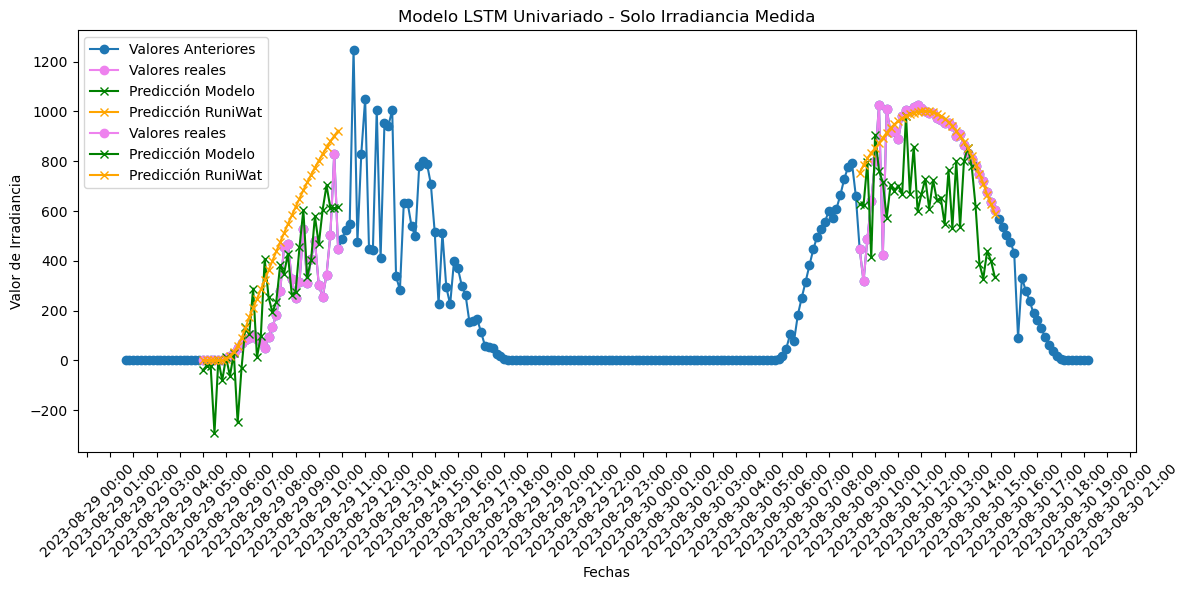

In [59]:
import matplotlib.dates as mdates

fechas_ =  [datetime.strptime(fecha_str[0], '%Y-%m-%d %H:%M')  for fecha_str in fechas_test]
fechas = [datetime.strptime(fecha_str, '%Y-%m-%d %H:%M') for fecha_str in fechas_predichas]
fechas2 = [datetime.strptime(fecha_str, '%Y-%m-%d %H:%M') for fecha_str in fechas_predichas_2]

plt.figure(figsize=(12, 6))

plt.plot(fechas_[500:750], y_test[500:750,0], label="Valores Anteriores", marker='o')
plt.plot(fechas, valores_reales, label='Valores reales', marker='o', color='violet')
plt.plot(fechas, valores_predichos[0], label='Predicción Modelo', marker='x', color='green')
plt.plot(fechas, df_rw_1['ghi'], label='Predicción RuniWat', marker='x', color='orange')

plt.plot(fechas2, valores_reales_2, label='Valores reales', marker='o', color='violet')
plt.plot(fechas2, valores_predichos_2[0], label='Predicción Modelo', marker='x', color='green')
plt.plot(fechas2, df_rw_2['ghi'], label='Predicción RuniWat', marker='x', color='orange')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Formatear las fechas
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Puedes ajustar el intervalo según tus datos

plt.xticks(rotation=45)
plt.legend()
plt.title('Modelo Irradiancia + Altura de las Nubes (ACHA-GOES)')
plt.xlabel('Fechas')
plt.ylabel('Valor de Irradiancia')
plt.tight_layout()
plt.show()

### Almacenar Modelo Entrenado

In [60]:
import joblib

# Guardar el modelo en un archivo
joblib.dump(model, 'modelo_ACHA.pkl')

['modelo_ACHA.pkl']